In [1]:
from os import listdir
from sys import argv

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import Binarizer, scale

from sklearn.svm import SVC

import time

from sklearn.externals import joblib

In [34]:
argv = [3, "imgs_orig", "gts_orig"]

path_imgs = sorted([ argv[1] + '/' + i for i in listdir(argv[1]) ])
path_gts = sorted([ argv[2] + '/' + i for i in listdir(argv[2]) ])

names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI", "PCA0", "PCA1"]

fpr = [np.array([0]) for i in range(6)]
tpr = [np.array([0]) for i in range(6)]
fpr2 = [np.array([0]) for i in range(6)]
tpr2 = [np.array([0]) for i in range(6)]

In [35]:
GT = np.load("VI_orig/Mini/GT.npy")

In [24]:
def gen_mat(features1, features2, features3, base, n_images):
    
    '''
    Função que gera a matriz com todas as features.
    
    Parâmetros:
    features1 - Lista de índices que correspondem as VIs sem informação contextual
    features2 - Lista de índides que correspondem as VIs geradas com a função neighbMin
    features3 - Lista de índices que correspondem as VIs geradas com a função neighbMax
    
    Os índices referidos variam de 0 a 7 e corresponem a seguinte lista:
    ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI", "PCA0", "PCA1"]
    
    Retorno:
    X - a matriz com todas as features escolhidas
    '''
    
    n_features = len(features1) + len(features2) + len(features3)
    
    X = np.zeros((512*512*n_images, n_features), dtype = float)
    
    s = 0
    for i in range(len(features1)):
        X[:, i + s] = np.load(base + "Mini/" + names_VI[features1[i]] + ".npy")
        
    s += len(features1)
    for i in range(len(features2)):
        X[:, i + s] = np.load(base + "MiniNBless/" + names_VI[features2[i]] + ".npy")
        
    s += len(features2)
    for i in range(len(features3)):
        X[:, i + s] = np.load(base + "MiniNBmax/" + names_VI[features3[i]] + ".npy")
    
    return X
    

In [36]:
X = gen_mat((1, 5, 6), (0, 2 , 3, 4, 6), (5, 6), "VI_orig/", len(path_imgs))

In [39]:
print(X.shape)
print(np.count_nonzero(X))
print(GT.shape)
print(np.count_nonzero(GT))

(9437184, 12)
113246159
(9437184,)
6706552


# PCA

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [38]:
X = np.column_stack((X, X_pca[:,0]))
X = np.column_stack((X, X_pca[:,1]))

# Shuffle

In [40]:
X = np.column_stack((X, GT))

In [41]:
print(X.shape)
print(np.count_nonzero(X))

(9437184, 13)
119952711


In [42]:
np.random.shuffle(X)

In [43]:
GT = X[:,-1]
X = X[:,:-1]
print(X.shape)
print(np.count_nonzero(X))
print(GT.shape)
print(np.count_nonzero(GT))

(9437184, 12)
113246159
(9437184,)
6706552


# Train / Validation

In [ ]:
X_train, X_test = np.split(X, [512*512*22], axis = 0)
y_train, y_test = np.split(GT, [512*512*22])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(np.count_nonzero(X_train))
print(np.count_nonzero(y_train))
print(np.count_nonzero(X_test))
print(np.count_nonzero(y_test))

# Treino

[0]	validation_0-auc:0.55938	validation_1-auc:0.558757
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.783743	validation_1-auc:0.783718
[2]	validation_0-auc:0.791321	validation_1-auc:0.791513
[3]	validation_0-auc:0.803971	validation_1-auc:0.804335
[4]	validation_0-auc:0.822733	validation_1-auc:0.822978
[5]	validation_0-auc:0.828951	validation_1-auc:0.829159
[6]	validation_0-auc:0.828383	validation_1-auc:0.828589
[7]	validation_0-auc:0.830559	validation_1-auc:0.830766
[8]	validation_0-auc:0.830526	validation_1-auc:0.830741
[9]	validation_0-auc:0.83027	validation_1-auc:0.830484
[10]	validation_0-auc:0.83044	validation_1-auc:0.830658
[11]	validation_0-auc:0.828745	validation_1-auc:0.828969
[12]	validation_0-auc:0.827237	validation_1-auc:0.82747
[13]	validation_0-auc:0.828216	validation_1-auc:0.828456
[14]	validation_0-auc:0.828074	validation_1-auc:0.828304
[1

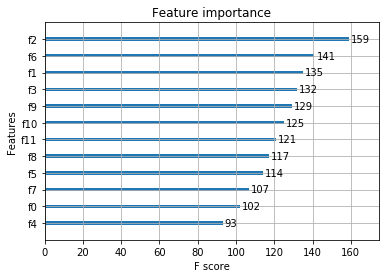

In [45]:
ratio = float(np.sum(GT == 1)) / np.sum(GT==0)

clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 2,
                n_estimators=100,
                learning_rate=0.1, 
                nthread=3,
                subsample=1.0,
                colsample_bytree=1/X.shape[1],
                #min_child_weight = 3,
                scale_pos_weight = ratio,
                reg_alpha=0.03,
                seed=1301)
                
clf.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
        eval_set=[(X_train, y_train), (X_test, y_test)])
        
print('Overall AUC:', roc_auc_score(y_test, clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,1]))
xgb.plot_importance(clf)

# Análise do Resultados

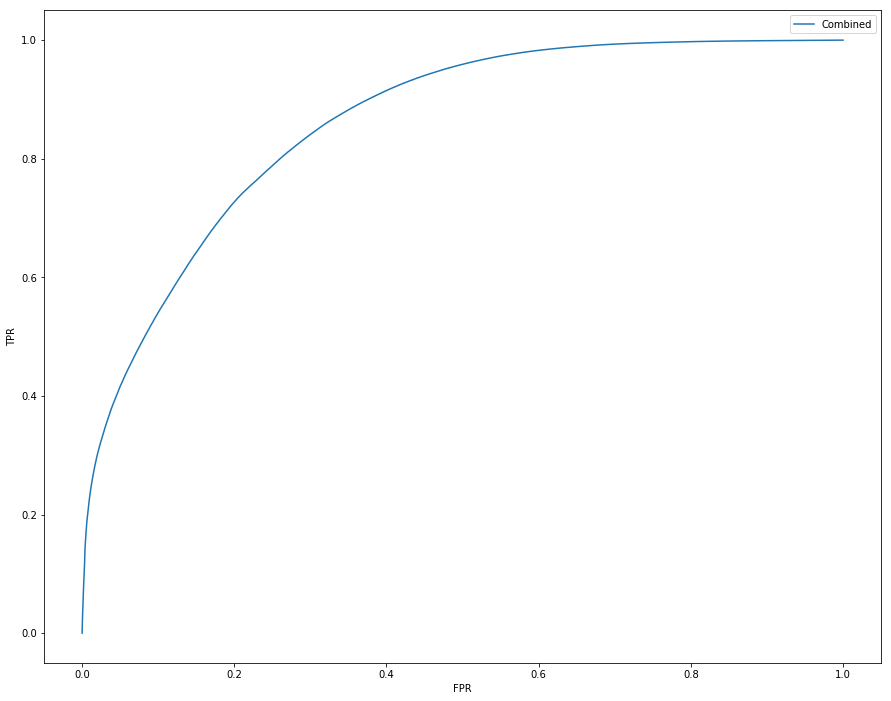

In [46]:
best_pred = clf.predict_proba(X_test, ntree_limit=clf.best_iteration)[:,1]
plt.figure(figsize=(15,12))
# for j in range(6):
#     plt.plot(fpr[j], tpr[j], label = names_VI[j])

FPR, TPR, _ = roc_curve(y_test, best_pred)
plt.plot(FPR, TPR, label = "Combined")
    
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')

In [47]:
# Melhor média de TPR E TNR
i_max = max(range(len(TPR)), key = lambda x : TPR[x] + 1 - FPR[x])
print((TPR[i_max] + 1 - FPR[i_max])/2)

0.77065864614


In [48]:
joblib.dump(clf, 'clf_VI_orig_02.pkl')
# clf = joblib.load('filename.pkl') 

['clf_VI_orig_02.pkl']